# Training the CNN

In [22]:
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

with open('param_dict.json') as f:
    content = f.read()

param_dict = json.loads(content)

labels = np.loadtxt("Datasets/Feature_extraction/labels.txt", dtype='str')
df_2d = np.loadtxt("Datasets/Feature_extraction/th_oct_feature.txt")
df = df_2d.reshape(df_2d.shape[0], df_2d.shape[1] // param_dict['n_bands'], param_dict['n_bands'])

(1132, 48, 21)


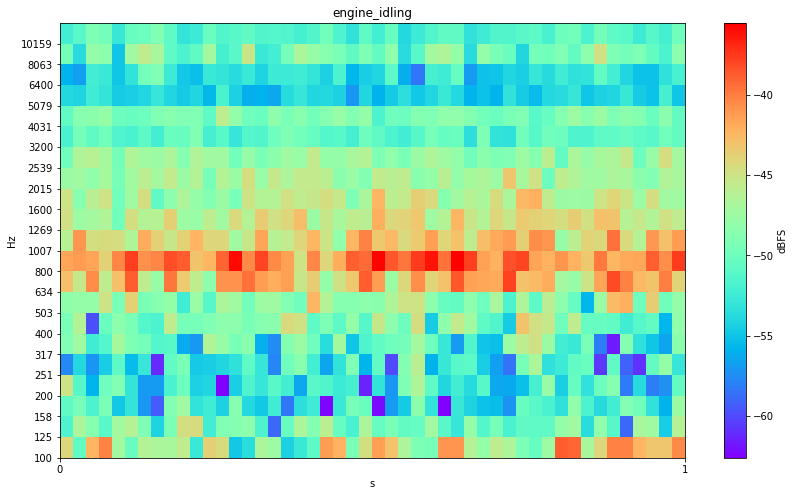

In [24]:
# sanity check:
import octafilt3r.plot as o3p

print(df.shape)
o3p.oct_spectrogram(df[600], param_dict['fs'], param_dict['frame_size'], param_dict['fmax'], param_dict['fmin'], param_dict['oct_bw_ratio'], labels[600])

In [62]:
def data_scaler(df):
    X = np.zeros((len(df), len(df[0]), len(df[0][0])))
    scaler = StandardScaler()
    for win in range(len(df)):
        X[win] = scaler.fit_transform(df[win])

    X = X[..., np.newaxis]

    return X, scaler


def label_encode(labels):
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)
    
    return y, encoder


y, encoder = label_encode(labels)
X, scaler = data_scaler(df)
print(f'Encoded labels:\n{y}')
print(f'Shape of data frame: {X.shape}')
# Dividing data into training and Testing set
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2)


Encoded labels:
[0 0 0 ... 6 6 6]
Shape of data frame: (1132, 48, 21, 1)


In [40]:
# https://gist.github.com/jaron/5b17c9f37f351780744aefc74f93d3ae
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2
from sklearn import metrics 

kernel_size = (5, 5)
n_classes = max(y_test) + 1 # highest index + 1 is the amount of classes
print(f'Input shape: {X[0].shape}')
print(f'Output shape: {n_classes}')

layer_1 = [
    Conv2D(24, kernel_size, padding='same', input_shape=X[0].shape),
    MaxPooling2D(pool_size=(2,2)),
    Activation('relu')
]

layer_2 = [
    Conv2D(48, kernel_size, padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Activation('relu')
]

layer_3 = [
    Conv2D(48, kernel_size, padding='valid'),
    Activation('relu'),
]

layer_4 = [
    Flatten(),
    Dropout(0.5),
    Dense(64, kernel_regularizer=l2(0.001)),
    Activation('relu')
]

layer_5 = [
    Dropout(0.5),
    Dense(n_classes, kernel_regularizer=l2(0.001)),
    Activation('softmax')
]

layers = layer_1 + layer_2 + layer_3 + layer_4 + layer_5
model = Sequential(layers)

sgd = SGD(learning_rate=0.001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.fit(X_train, y_train, batch_size=4, epochs=150)

Input shape: (48, 21, 1)
Output shape: 7


In [63]:
# determine the ROC AUC score 
y_prob = model.predict(X_test)
y_true = np.argmax(y_prob, 1)
roc = metrics.roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC: {round(roc,3)}")

score, accuracy = model.evaluate(X_test, y_test, batch_size=4)
print("\nAccuracy = {:.2f}".format(accuracy))

ROC: 0.994
57/57 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.9031

Accuracy = 0.90


In [1]:
import librosa as lr
import octafilt3r.filter as o3f
import octafilt3r.plot as o3p

base_path = "Datasets/UrbanSound8k_augmented/street_music/"
fname = "34866-9-0-5.wav"

wav, fs = lr.load(base_path + fname, sr=param_dict['fs'], duration=1)

feats, fcs = o3f.rolling_oct_bank(
    wav,
    fs,
    param_dict['oct_bw_ratio'],
    param_dict['order'],
    param_dict['fmax'],
    param_dict['fmin'],
    param_dict['frame_size'],
    param_dict['dec_stages'],
    param_dict['dec_ord']
)

class_map = [
    'car_horn',
    'children_playing',
    'dog_bark',
    'drilling',
    'engine_idling',
    'jackhammer',
    'street_music'
]

o3p.oct_spectrogram(feats, fs, param_dict['frame_size'], param_dict['fmax'], param_dict['fmin'], param_dict['oct_bw_ratio'], fname)

feats = feats[np.newaxis, ...]
X, scaler = data_scaler(feats)

p = model.predict(X)
print(f'Predicted class: "{class_map[np.argmax(p)]}" with {int(100 * (p[0][np.argmax(p, 1)][0]))}% accuracy.')



NameError: name 'param_dict' is not defined